# AoA-AR 2D Surrogate on Forces 

This notebook contains the data filtering and error assessment of various 2D surrogates including polynomial and radial basis functions.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import Rbf

In [2]:
foldername = 'aoa_ar_forces'
cwd = os.getcwd()
os.chdir(cwd+'/'+foldername+'/')
data_pandas = pd.read_csv(foldername+'.csv') 

In [3]:
data_numpy = data_pandas.to_numpy()
AoA_deg = data_numpy[:,2]
AR      = data_numpy[:,3]
lift    = data_numpy[:,4]
drag    = data_numpy[:,5]
print(type(data_numpy[:,1]))
print(data_numpy[:,1])
data_pandas.head()

<class 'numpy.ndarray'>
['0_0' '1_0' '2_0' '3_0' '4_0' '5_0' '6_0' '0_1' '1_1' '2_1' '3_1' '4_1'
 '5_1' '6_1' '0_2' '1_2' '2_2' '3_2' '4_2' '5_2' '6_2' '0_3' '1_3' '2_3'
 '3_3' '4_3' '5_3' '6_3' '0_4' '1_4' '2_4' '3_4' '4_4' '5_4' '6_4' '0_5'
 '1_5' '2_5' '3_5' '4_5' '5_5' '6_5' '0_6' '1_6' '2_6' '3_6' '4_6' '5_6'
 '6_6']


,Unnamed: 0,label,AoA_deg,ar,lift,drag,my
0,0,0_0,0.0,20.0,1.195906e-11,2.979985e-26,1.398913e-12
1,1,1_0,0.6,20.0,1.277337e+02,1.507186e-01,8.861840e+00
2,2,2_0,1.2,20.0,2.518025e+02,5.852986e-01,1.746129e+01
3,3,3_0,1.8,20.0,3.711550e+02,1.269414e+00,2.573061e+01
4,4,4_0,2.4,20.0,4.845854e+02,2.181491e+00,3.359431e+01


## Filter points into training and testing

In [44]:
num_models = len(data_numpy[:,1])
i_train = np.arange(0,num_models+1,2)
i_test = np.arange(1,num_models,2)
x1 = AoA_deg[i_train]
x1_test = AoA_deg[i_test]
x2 = AR[i_train]
x2_test = AR[i_test]
lift_test = lift[i_test]
print('num of training points = ',len(i_train))
print('num of testing points = ',len(i_test))

num of training points =  25
num of testing points =  24


Text(0.5, 0, 'AR')

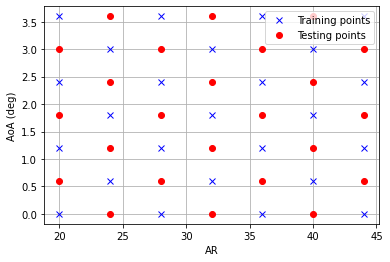

In [5]:
# Plot the points used
fig1, ax = plt.subplots()

ax.plot(x2,x1,'bx')
ax.plot(x2_test,x1_test,'ro')


ax.legend(["Training points","Testing points"])
ax.grid(True)
ax.set_ylabel('AoA (deg)')
ax.set_xlabel('AR')


## Lift 2D surrogate

Text(0.5, 0, 'AoA (deg)')

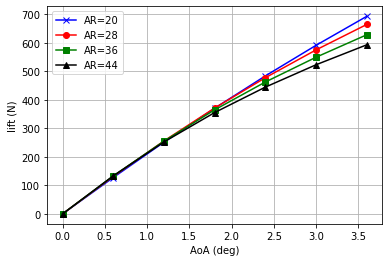

In [6]:
# Plot lift for different AR's
x = AoA_deg[0:7]
lift0 = lift[0:7]
lift1 = lift[7:14]
lift2 = lift[14:21]
lift3 = lift[21:28]
lift4 = lift[28:35]
lift5 = lift[35:42]
lift6 = lift[42:49]

fig2, ax = plt.subplots()

ax.plot(x,lift0,'bx-')
ax.plot(x,lift2,'ro-')
ax.plot(x,lift4,'gs-')
ax.plot(x,lift6,'k^-')


ax.legend(["AR=20","AR=28","AR=36","AR=44"])
ax.grid(True)
ax.set_ylabel('lift (N)')
ax.set_xlabel('AoA (deg)')


## Fit a 2D surrogate to the data

Decided that lift should be 2nd order wrt to AoA and 3rd order wrt to AR.


In [24]:
def polynomial_basis2D(x,y,kx,ky):
    """Evaluates a vector using a kth degree polynomial in two directions.

    Args:
        x (np.array): Vector of points to be evaluated 
        y (np.array): Vector of points to be evaluated
        kx     (int): Degree polynomial in variable x
        ky     (int): Degree polynomial in varibale y
    Returns:
        b (np.array): 2D array with evaluations of x,y for every point

    """
    num = x.size
    num2 = y.size
    if num != num2:
        print('Vectors x and y must be the same size')
    else:
        b = np.zeros([num,(kx+1)*(ky+1)])
        for k in range(num):
            counter = 0
            for i in range(kx+1):
                for j in range(ky+1):
                    b[k,counter] = x[k]**(i)*y[k]**(j)
                    counter+=1
    return b


In [12]:
#test the function
x = x1
y = x2
kx = 2
ky = 3
b = polynomial_basis2D(x,y,kx,ky)
print(b)

[[1.00000000e+00 2.00000000e+01 4.00000000e+02 8.00000000e+03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 2.00000000e+01 4.00000000e+02 8.00000000e+03
  1.20000000e+00 2.40000000e+01 4.80000000e+02 9.60000000e+03
  1.44000000e+00 2.88000000e+01 5.76000000e+02 1.15200000e+04]
 [1.00000000e+00 2.00000000e+01 4.00000000e+02 8.00000000e+03
  2.40000000e+00 4.80000000e+01 9.60000000e+02 1.92000000e+04
  5.76000000e+00 1.15200000e+02 2.30400000e+03 4.60800000e+04]
 [1.00000000e+00 2.00000000e+01 4.00000000e+02 8.00000000e+03
  3.60000000e+00 7.20000000e+01 1.44000000e+03 2.88000000e+04
  1.29600000e+01 2.59200000e+02 5.18400000e+03 1.03680000e+05]
 [1.00000000e+00 2.40000000e+01 5.76000000e+02 1.38240000e+04
  6.00000000e-01 1.44000000e+01 3.45600000e+02 8.29440000e+03
  3.60000000e-01 8.64000000e+00 2.07360000e+02 4.97664000e+03]
 [1.00000000e+00 2.40000000e+01 5.76000000e+02 1.38240000e+04
  1

In [15]:
def eval_parameter(f,b):
    """ Function evaluates a theta matrix which solves a least squares
    problem: [theta]=[B^+]{f} where [B^+] is the Moore-Penrose Pseudo Inverse
    These points can then be used to evaluate the polynomial via:
    f(x) = theta[0]*b[0]+theta[1]*b[1]+...+theta[k+1]*b[k+1]"""

    y     = np.matrix(f).T # Use a column vector
    bpinv = np.matrix(np.linalg.pinv(b)) # calculate the pseudo inverse
    theta = bpinv*y
    return theta

In [16]:
theta = eval_parameter(lift[i_train],b)
print(theta)

[[24.48301136253231]
 [-2.57936690010576]
 [0.08405293092658066]
 [-0.0008549538987765901]
 [144.02380050725606]
 [6.3605885381284395]
 [-0.1530192352763553]
 [0.0011971714382612714]
 [7.958678288266924]
 [-0.8848679114657614]
 [0.005084472819075092]
 [3.53679944523691e-05]]


In [26]:
def eval_surrogate(theta,x,y,kx,ky):
    """ Function which evaluates the surrogate function

    Args:
        x (np.array): Points at which surrogate output is seeked
        y (np.array): Second dimension of points to evaluate surrogate at
        kx     (int): Degree polynomial in variable x
        ky     (int): Degree polynomial in varibale y
    Returns
        f (np.array): Evaluations of the surrogate
    """
    f = np.zeros([len(x), ])
    params = theta
    for i in range(len(x)):
        btest = polynomial_basis2D(np.array([x[i]]),np.array([y[i]]),kx,ky)
        f[i] = np.dot(btest, params)

    return f


In [36]:
xp = np.linspace(0,3.6,100)
yp0 = AR[0]*np.ones(xp.shape)
yp1 = AR[7]*np.ones(xp.shape)
yp2 = AR[14]*np.ones(xp.shape)
yp3 = AR[21]*np.ones(xp.shape)
yp4 = AR[28]*np.ones(xp.shape)
yp5 = AR[35]*np.ones(xp.shape)
yp6 = AR[42]*np.ones(xp.shape)

lift0surr = eval_surrogate(theta,xp,yp0,kx,ky)
lift1surr = eval_surrogate(theta,xp,yp1,kx,ky)
lift2surr = eval_surrogate(theta,xp,yp2,kx,ky)
lift3surr = eval_surrogate(theta,xp,yp3,kx,ky)
lift4surr = eval_surrogate(theta,xp,yp4,kx,ky)
lift5surr = eval_surrogate(theta,xp,yp5,kx,ky)
lift6surr = eval_surrogate(theta,xp,yp6,kx,ky)

Text(0.5, 0, 'AoA (deg)')

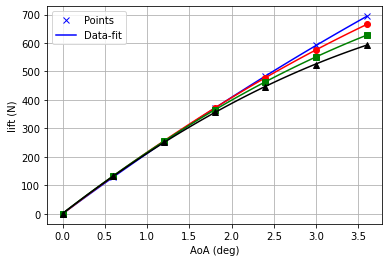

In [37]:
# Plot lift for different AR's
x = AoA_deg[0:7]
# lift0 = lift[0:7]
# lift1 = lift[7:14]
# lift2 = lift[14:21]
# lift3 = lift[21:28]
# lift4 = lift[28:35]
# lift5 = lift[35:42]
# lift6 = lift[42:49]

fig3, ax = plt.subplots()

ax.plot(x,lift0,'bx')
ax.plot(xp,lift0surr,'b-')
ax.plot(x,lift2,'ro')
ax.plot(xp,lift2surr,'r-')
ax.plot(x,lift4,'gs')
ax.plot(xp,lift4surr,'g-')
ax.plot(x,lift6,'k^')
ax.plot(xp,lift6surr,'k-')

ax.legend(["Points","Data-fit"])
ax.grid(True)
ax.set_ylabel('lift (N)')
ax.set_xlabel('AoA (deg)')

## Obtain the errors

In [48]:
def eval_error(f_test,theta,x_test,y_test,kx,ky):
    """ Function to evaluate the error in a model
    
    eval_errors(f_test,theta,x_test,y_test,kx,ky) calculates
    the means squared error from a set of 2D testing points with 
    outputs f_test
    
    Args:
        f_test  (np.array): True testing outputs from the model
        theta   (np.array): Parameters from the surrogate
        x_test  (np.array): Testing points from the first design parameter
        y_test  (np.array): Testing points from the second design parameter
        kx     (int): Degree polynomial in variable x
        ky     (int): Degree polynomial in varibale y
    Returns:
        error   (float): Mean squared error

    """
    error=0 # Initialize the error
    f_surr = eval_surrogate(theta,x_test,y_test,kx,ky)
    for i in range(len(f_test)):
        error+=(f_test[i]-f_surr[i])**2
    error = error/len(f_test)
    
    return error
        

In [49]:
error_lift = eval_error(lift_test,theta,x1_test,x2_test,kx,ky)
print(error_lift)

1.0395064947302721


In [54]:
# Test with a higher degree polynomial
kx = 3
b2 = polynomial_basis2D(x1,x2,kx,ky)
theta2 = eval_parameter(lift[i_train],b2)
error_lift2 = eval_error(lift_test,theta2,x1_test,x2_test,kx,ky)

In [55]:
print(error_lift2)

0.20888567097235436
